In [1]:
# Standard library imports
import os

# Scientific computing libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Time series analysis libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models

# Utility libraries
import optuna # Hyperparameter optimization
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances
from tqdm import tqdm  # Progress bar visualization

# Custom libraries
from effKAN import KAN

In [2]:
#read car data
data = pd.read_csv('./data/car_data.csv')

In [3]:
data.head()

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


In [5]:
#check for missing values
data.isnull().sum()

Car_id           0
Date             0
Customer Name    1
Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Phone            0
Dealer_Region    0
dtype: int64

In [6]:
data = data.fillna('0')

# Graph

## Univariable Analysis

## Bivariable Analysis

## Multi-variate Analysis

# Convert, Encode, Normalization

## Convert `Date` to independent variable

In [12]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data = data.drop(['Date'], axis=1)

## Encoding

In [13]:
data = data.drop(['Car_id','Customer Name'], axis=1)

In [14]:
object_columns = data.select_dtypes(include=['object']).columns

le = LabelEncoder()
for i in range(len(object_columns)):
    data[object_columns[i]] = le.fit_transform(data[object_columns[i]])

## Normalizing

In [15]:
num_columns = data.select_dtypes(include=['int64', 'float64', 'int32']).columns
num_columns = num_columns.drop(['Price ($)'])

scaler = MinMaxScaler()
for i in range(len(num_columns)):
    data[num_columns[i]] = scaler.fit_transform(data[num_columns[i]].values.reshape(-1, 1))

# Features Analysis

In [16]:
data.head()

,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Year,Month,Day
0,1.0,0.000306,0.000000,0.275862,0.392157,0.0,0.0,0.0,26000,0.000000,0.75,0.754990,0.666667,0.0,0.0,0.033333
1,1.0,0.131361,0.037037,0.241379,0.339869,0.0,0.0,0.0,19000,0.500000,0.75,0.282745,0.000000,0.0,0.0,0.033333
2,1.0,0.091593,0.074074,0.137931,0.372549,1.0,1.0,1.0,31500,0.166667,0.50,0.432974,0.333333,0.0,0.0,0.033333
3,1.0,0.000306,0.148148,0.931034,0.235294,1.0,1.0,0.5,14000,1.000000,0.75,0.085834,0.833333,0.0,0.0,0.033333
4,1.0,0.130021,0.111111,0.000000,0.921569,0.0,0.0,1.0,24500,0.333333,0.25,0.360523,0.500000,0.0,0.0,0.033333


In [17]:
summary_stats = data.describe()

print("Summary of Statistics:")
summary_stats

Summary of Statistics:


,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Year,Month,Day
count,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000,23906.000000
mean,0.786330,0.073348,0.587790,0.489945,0.508799,0.474149,0.474149,0.435916,28090.247846,0.509091,0.534301,0.499300,0.492338,0.554714,0.622993,0.482435
std,0.409905,0.064344,0.299926,0.300222,0.287410,0.499342,0.499342,0.358033,14788.687608,0.326349,0.330933,0.289214,0.331089,0.497008,0.296180,0.291139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.033595,0.333333,0.215517,0.274510,0.000000,0.000000,0.000000,18001.000000,0.166667,0.250000,0.248841,0.166667,0.000000,0.363636,0.233333
50%,1.000000,0.064783,0.666667,0.517241,0.529412,0.000000,0.000000,0.500000,23000.000000,0.500000,0.500000,0.498786,0.500000,1.000000,0.727273,0.466667
75%,1.000000,0.104171,0.851852,0.724138,0.751634,1.000000,1.000000,0.500000,34000.000000,0.833333,0.750000,0.749479,0.833333,1.000000,0.909091,0.733333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,85800.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Skewness and kurtosis
skewness = data.skew()
kurtosis = data.kurtosis()
# Display skewness and kurtosis values
print("\nSkewness:")
print(skewness)
print("\nKurtosis:")
print(kurtosis)


Skewness:
Gender          -1.397171
Annual Income    1.739838
Dealer_Name     -0.436012
Company          0.140170
Model           -0.109266
Engine           0.103550
Transmission     0.103550
Color            0.193628
Price ($)        1.466316
Dealer_No       -0.053531
Body Style      -0.088763
Phone            0.000863
Dealer_Region    0.070238
Year            -0.220193
Month           -0.415582
Day              0.036949
dtype: float64

Kurtosis:
Gender          -0.047918
Annual Income    7.572374
Dealer_Name     -1.059227
Company         -1.242038
Model           -1.134052
Engine          -1.989444
Transmission    -1.989444
Color           -1.041766
Price ($)        2.008315
Dealer_No       -1.217015
Body Style      -1.231417
Phone           -1.197919
Dealer_Region   -1.239599
Year            -1.951678
Month           -0.994360
Day             -1.190651
dtype: float64


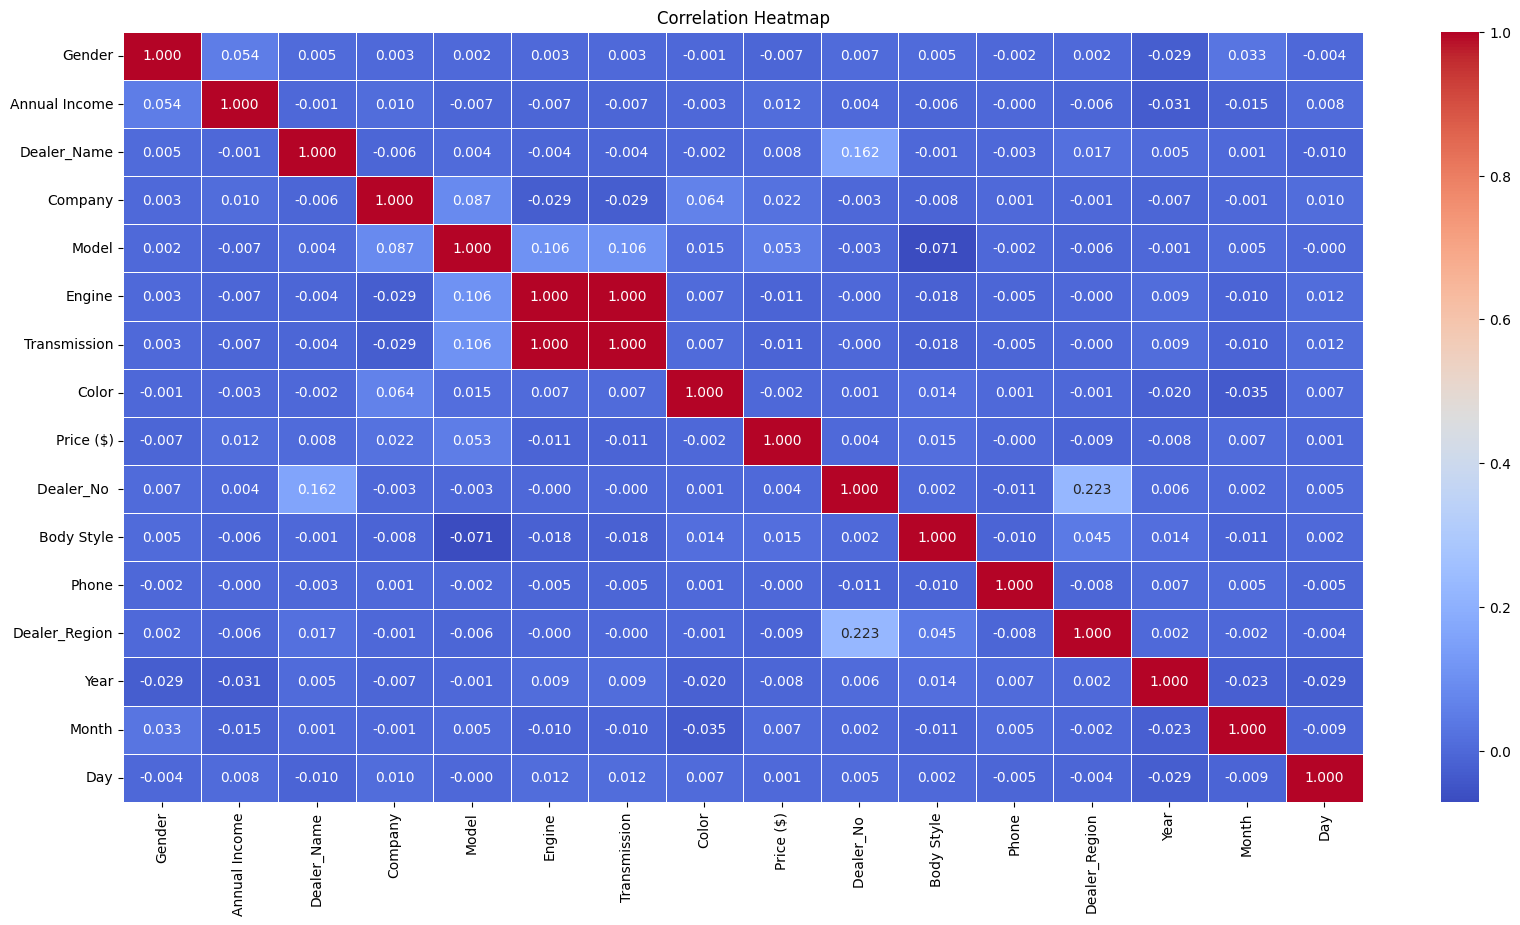

In [19]:
# Correlation matrix
correlation_matrix = data.corr()

# Correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt = ".3f")
plt.title("Correlation Heatmap")
plt.show()

In [20]:
# Calculate Multicollinearity
y = data.drop(["Price ($)"], axis =1)
X = sm.add_constant(y)

# Calculate VIF for each variable
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

         variable        VIF
0           const  34.660726
1          Gender   1.004938
2   Annual Income   1.004512
3     Dealer_Name   1.027468
4         Company   1.013523
5           Model   1.024921
6          Engine        inf
7    Transmission        inf
8           Color   1.006165
9      Dealer_No    1.081081
10     Body Style   1.007967
11          Phone   1.000395
12  Dealer_Region   1.055150
13           Year   1.003951
14          Month   1.003449
15            Day   1.001464


c:\Users\27929\anaconda3\envs\tensorflow_cpu\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [21]:
high_vif_variables = vif[vif["VIF"] >= 5]["variable"]
regression_data = X.drop(high_vif_variables, axis=1)

regression_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         23906 non-null  float64
 1   Annual Income  23906 non-null  float64
 2   Dealer_Name    23906 non-null  float64
 3   Company        23906 non-null  float64
 4   Model          23906 non-null  float64
 5   Color          23906 non-null  float64
 6   Dealer_No      23906 non-null  float64
 7   Body Style     23906 non-null  float64
 8   Phone          23906 non-null  float64
 9   Dealer_Region  23906 non-null  float64
 10  Year           23906 non-null  float64
 11  Month          23906 non-null  float64
 12  Day            23906 non-null  float64
dtypes: float64(13)
memory usage: 2.4 MB


# Regression

## KAN

## ResNet

# Linear Sequence Analysis

## ARIMA

In [ ]:
p = 2
d = 0 
q = 1

In [ ]:
data.head()

,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Year,Month,Day
0,1.0,0.000306,0.000000,0.275862,0.392157,0.0,0.0,0.0,26000,0.000000,0.75,0.754990,0.666667,0.0,0.0,0.033333
1,1.0,0.131361,0.037037,0.241379,0.339869,0.0,0.0,0.0,19000,0.500000,0.75,0.282745,0.000000,0.0,0.0,0.033333
2,1.0,0.091593,0.074074,0.137931,0.372549,1.0,1.0,1.0,31500,0.166667,0.50,0.432974,0.333333,0.0,0.0,0.033333
3,1.0,0.000306,0.148148,0.931034,0.235294,1.0,1.0,0.5,14000,1.000000,0.75,0.085834,0.833333,0.0,0.0,0.033333
4,1.0,0.130021,0.111111,0.000000,0.921569,0.0,0.0,1.0,24500,0.333333,0.25,0.360523,0.500000,0.0,0.0,0.033333


## LSTM Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import optuna

X = data.drop(['Price ($)'], axis=1)
y = data['Price ($)']

print(X.shape)
print(y.shape)

X = X.values
y = y.values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    
def objective(trial):
    input_size = X_train.shape[1]
    hidden_size = trial.suggest_int('hidden_size', 10, 100)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    model = LSTMRegressor(input_size, hidden_size, num_layers, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    return val_loss / len(test_loader)

input_size = 15
output_size = 1

num_epochs = 100

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print(f'Best hyperparameters: {study.best_params}')

best_params = study.best_params
input_size = 15
hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
learning_rate = best_params['learning_rate']

model = LSTMRegressor(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

[I 2024-06-11 19:25:47,161] A new study created in memory with name: no-name-b21b0829-dd99-41f7-9c60-9706ee333b21


(23906, 15)
(23906,)


C:\Users\27929\AppData\Local\Temp\ipykernel_15364\1312012039.py:63: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-06-11 19:26:04,677] Trial 0 finished with value: 905840986.9473684 and parameters: {'hidden_size': 68, 'num_layers': 3, 'learning_rate': 0.009604375771893098}. Best is trial 0 with value: 905840986.9473684.
[I 2024-06-11 19:26:12,744] Trial 1 finished with value: 985697522.5263158 and parameters: {'hidden_size': 41, 'num_layers': 1, 'learning_rate': 0.00010240992981647201}. Best is trial 0 with value: 905840986.9473684.
[I 2024-06-11 19:26:22,003] Trial 2 finished with value: 984647851.7894737 and parameters: {'hidden_size': 11, 'num_layers': 2, 'learning_rate': 0.0010428750737022847}. Best is trial 0 with value: 905840986.9473684.
[I 2024

Best hyperparameters: {'hidden_size': 99, 'num_layers': 3, 'learning_rate': 0.009930293138566462}
Epoch [1/100], Loss: 1057442176.0000
Epoch [2/100], Loss: 1185961216.0000
Epoch [3/100], Loss: 949571328.0000
Epoch [4/100], Loss: 1285686272.0000
Epoch [5/100], Loss: 780838016.0000
Epoch [6/100], Loss: 593562624.0000
Epoch [7/100], Loss: 956433472.0000
Epoch [8/100], Loss: 1004327360.0000
Epoch [9/100], Loss: 1116131072.0000
Epoch [10/100], Loss: 1151618048.0000
Epoch [11/100], Loss: 761589696.0000
Epoch [12/100], Loss: 919185536.0000
Epoch [13/100], Loss: 657783680.0000
Epoch [14/100], Loss: 711098752.0000
Epoch [15/100], Loss: 1274133760.0000
Epoch [16/100], Loss: 956707776.0000
Epoch [17/100], Loss: 990253632.0000
Epoch [18/100], Loss: 1088042496.0000
Epoch [19/100], Loss: 846770176.0000
Epoch [20/100], Loss: 866398208.0000
Epoch [21/100], Loss: 783386368.0000
Epoch [22/100], Loss: 875123008.0000
Epoch [23/100], Loss: 960910400.0000
Epoch [24/100], Loss: 1147389952.0000
Epoch [25/100]

IndexError: too many indices for tensor of dimension 2

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch.unsqueeze(1))
        loss = criterion(outputs, y_batch)/len(train_loader)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'./save/model_{current_time}.pth'
torch.save(model.state_dict(), file_name)

model.eval()
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch.unsqueeze(1))
        loss = criterion(outputs, y_batch)/len(test_loader)
        test_loss += loss.item()
    
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], Loss: 3926002.0000
Epoch [2/100], Loss: 3180090.5000
Epoch [3/100], Loss: 4372248.5000
Epoch [4/100], Loss: 2117259.5000
Epoch [5/100], Loss: 2425939.5000
Epoch [6/100], Loss: 2049752.3750
Epoch [7/100], Loss: 4972850.5000
Epoch [8/100], Loss: 2637219.7500
Epoch [9/100], Loss: 4748933.5000
Epoch [10/100], Loss: 2877569.5000
Epoch [11/100], Loss: 3460804.7500
Epoch [12/100], Loss: 3790552.7500
Epoch [13/100], Loss: 3164951.5000
Epoch [14/100], Loss: 3649116.5000
Epoch [15/100], Loss: 4093758.2500
Epoch [16/100], Loss: 3355591.2500
Epoch [17/100], Loss: 4155329.7500
Epoch [18/100], Loss: 2796431.2500
Epoch [19/100], Loss: 4689971.5000
Epoch [20/100], Loss: 4117758.2500
Epoch [21/100], Loss: 5546599.0000
Epoch [22/100], Loss: 3362803.5000
Epoch [23/100], Loss: 2920908.5000
Epoch [24/100], Loss: 3421660.7500
Epoch [25/100], Loss: 2882243.7500
Epoch [26/100], Loss: 2057182.2500
Epoch [27/100], Loss: 3255043.7500
Epoch [28/100], Loss: 3454728.0000
Epoch [29/100], Loss: 1647929

In [ ]:
print(X)
print(y)

[[1.00000000e+00 3.05632212e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.33333333e-02]
 [1.00000000e+00 1.31361082e-01 3.70370370e-02 ... 0.00000000e+00
  0.00000000e+00 3.33333333e-02]
 [1.00000000e+00 9.15931481e-02 7.40740741e-02 ... 0.00000000e+00
  0.00000000e+00 3.33333333e-02]
 ...
 [1.00000000e+00 6.21023207e-02 1.48148148e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 3.05632212e-04 1.11111111e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.08572715e-01 5.92592593e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
[26000 19000 31500 ... 21000 31000 27500]


In [ ]:
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('./save/model_20240611_193725.pth'))
model.eval()

with torch.no_grad():
    test_data = data.head(1).drop(columns=['Price ($)'])
    test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32).unsqueeze(1)
    predictions = model(test_data_tensor).numpy()
    print(predictions)


[[5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]
 [5787.2856]